*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Se importan librerías. Quizá se usen o no todas ellas.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version solo existe en Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Se importan los datos
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-01-26 01:44:57--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv.5’

insurance.csv.5         [ <=>                ]  49.09K  --.-KB/s    in 0.001s  

2021-01-26 01:44:58 (46.2 MB/s) - ‘insurance.csv.5’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


First of all, we are going to check if there is any missing value in the dataframe.

In [3]:
dataset.isnull().sum() # Hacemos la suma de todos los valores nulos de cada columna.

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

As we can see, there aren't missing values in the dataframe.

Now we use the *one hot encoding* technique to convert all the categorical data in numerical data with the `get_dummies` method from pandas. This increase the number of columns as you can see below:

In [4]:
dataset_numeric = pd.get_dummies(dataset, columns=["sex","smoker","region"]) # @get_dummies: Convierte los datos categóricos de 
                                                                             # las columnas seleccionadas en datos numéricos.
dataset_numeric.head() # Muestra los 5 primeros resultados de la tabla.

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,1,0,0,1,0,0,0,1
1,18,33.8,1,1725.55,0,1,1,0,0,0,1,0
2,28,33.0,3,4449.46,0,1,1,0,0,0,1,0
3,33,22.7,0,21984.47,0,1,1,0,0,1,0,0
4,32,28.9,0,3866.86,0,1,1,0,0,1,0,0


After that, we are going to use the 80% of the data as the train_dataset and 20% of the data as the test_dataset. For that, we use the `train_test_split` library to split and create these subsets of data.

In [5]:
from sklearn.model_selection import train_test_split # Se importa la librería para dividir los datos en entreno y test.

train_dataset, test_dataset = train_test_split(dataset_numeric, test_size=0.2) # @train_test_split: Divide el dataset numérico en dos
                                                                               # subconjuntos de datos: uno de entreno y otro de test 
                                                                               # (ambos con filas aleatorias).
                                                                               # @test_size: Establece el tamaño del subconjunto de 
                                                                               # test (20%).

Now that we have split the dataset it's time to pop off the `expenses` column from these datasets to create new datasets called `train_labels` and `test_labels`. This is done because the `expenses` column is the label (y) of our dataframe.

In [6]:
train_labels = train_dataset.pop('expenses') # @pop: Elimina la columna seleccionada y la almacena en otra variable.
test_labels = test_dataset.pop('expenses') # @pop: Elimina la columna seleccionada del dataset original y la almacena en otra variable.

We have now the features and the labels for the train and test datasets split in two different variables too. We can see this in the two next cells, where we show the first 5 rows of the `train_dataset` and `train_labels` variables.

In [7]:
train_dataset.head() # @head: Devuelve las 5 primeras filas

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
31,18,26.3,0,1,0,1,0,1,0,0,0
1186,20,35.6,3,0,1,0,1,0,1,0,0
1011,43,20.1,2,0,1,0,1,0,0,1,0
905,26,29.4,2,1,0,1,0,1,0,0,0
1270,26,33.9,1,0,1,1,0,0,1,0,0


As we can see above, the `expenses` column has disappeared from the features dataset and it's now stored in the labels dataset:

In [8]:
train_labels.head() # @head: Devuelve las 5 primeras filas

31       2198.19
1186    37465.34
1011    18767.74
905      4564.19
1270     3292.53
Name: expenses, dtype: float64

With the dataset and the labels split in two different variables we are now in conditions to create the model we are going to train. To do so, we use a neural network with dense layers and ReLU as an activation function, cause the output will have a value from zero to infinity.

In [9]:
model = keras.Sequential() # @Sequential: Agrupa una pila de capas al modelo de la red.
model.add(layers.Dense(512, activation='relu', input_shape=(len(train_dataset.keys()),))) # @input_shape: Establece la forma de entrada 
                                                                                          # a la red. En este caso, el número de
                                                                                          # columnas del dataframe (11, ).
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary() # @summary: Imprime por pantalla un resumen de la red neuronal definida.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               6144      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,041
Trainable params: 39,041
Non-trainable params: 0
_________________________________________________________________


Now that we have created and defined our model it's time to compile it. To do so, we define a loss function and a optimizer:
- The loss function is the function used to estimate the loss of the model.
- The optimizer change the parameters of the neural network with the goal of minimizing the loss function.

The goal is to reach the global minimum of the loss function, so that the neural network is perfect.

In [10]:
model.compile(loss='mse', # Esta función de loss se suele usar para problemas de regresión lineal como el actual.
              optimizer=keras.optimizers.Adam(lr = 0.01), # Optimizador para actualizar los pesos y sesgos de la red neuronal.
                                                             # lr: Learning rate (tamaño de los pasos para alcanzar el mínimo global 
                                                             # de la función de loss).
              metrics=['mae','mse']) # Se utiliza tanto el error cuadrático medio como el error absoluto medio entre las 
                                     # etiquetas (labels) y las predicciones como métricas para evaluar el rendimiento del modelo. 
                                     # Se requieren estas dos métricas como se verá más adelante para pasar el desafío.

As we can see above, we have defined in addition as a metrics the mean absolute error and the mean square error, so we can evaluate the performance of the model with these two metrics.

Once the model has been compiled, we only have to train it using the `fit` method.

In [11]:
model.fit(x= train_dataset, # Datos de entrada.
          y= train_labels, # Datos de salida.
          epochs=150, # Número de iteraciones sobre el dataset para entrenar el modelo.
          verbose=2, # Barra de progreso de entrenamiento.
          validation_split=0.2) # Fracción de los datos de entrenamiento que van a ser usados como datos de validación.

Epoch 1/150
27/27 - 1s - loss: 251393440.0000 - mae: 10872.1709 - mse: 251393440.0000 - val_loss: 130596616.0000 - val_mae: 9760.5000 - val_mse: 130596616.0000
Epoch 2/150
27/27 - 0s - loss: 135032016.0000 - mae: 9408.4844 - mse: 135032016.0000 - val_loss: 129448032.0000 - val_mae: 8082.4565 - val_mse: 129448032.0000
Epoch 3/150
27/27 - 0s - loss: 132429624.0000 - mae: 8965.5283 - mse: 132429624.0000 - val_loss: 122932568.0000 - val_mae: 8487.0732 - val_mse: 122932568.0000
Epoch 4/150
27/27 - 0s - loss: 125413232.0000 - mae: 9019.7666 - mse: 125413232.0000 - val_loss: 118687264.0000 - val_mae: 8904.9629 - val_mse: 118687264.0000
Epoch 5/150
27/27 - 0s - loss: 122769280.0000 - mae: 8777.6914 - mse: 122769280.0000 - val_loss: 114349656.0000 - val_mae: 8508.0273 - val_mse: 114349656.0000
Epoch 6/150
27/27 - 0s - loss: 117082288.0000 - mae: 8739.1094 - mse: 117082288.0000 - val_loss: 108463680.0000 - val_mae: 8208.5947 - val_mse: 108463680.0000
Epoch 7/150
27/27 - 0s - loss: 109696720.0000

Now that we have trained the model, we can make single predictions. For example, we calculate the medical charge of someone with these factors:
- **Age**: 35
- **BMI**: 23
- **Childrens**: 1 
- **Sex**: Male
- **Smoker**: No
- **Region**: Northeast

In [12]:
# age-bmi-children-sex_female-sex_male-smoker_no-smoker_yes-region_northeast-region_northwest-region_southeast-region_southwest
print(model.predict([[35,23,1,0,1,1,0,1,0,0,0]])) # @predict: Genera predicciones para los ejemplos de entrada.

[[6328.9653]]


As we can see, the medical charge of someone with these factors is $6328,97.

Now that we have completed everything in order to run the last cell, we can already run it to check if we pass the challenge or not.

9/9 - 0s - loss: 24962238.0000 - mae: 2680.8638 - mse: 24962238.0000
Testing set Mean Abs Error: 2680.86 expenses
You passed the challenge. Great job!


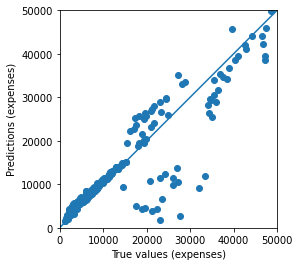

In [13]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2) # Devuelve el valor de la loss y de las dos métricas 
                                                                      # para el modelo.

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500: # Si el error cuadrático medio es menor de 3.500...
  print("You passed the challenge. Great job!") 
else: # Sino...
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten() # Genera predicciones de salida para los ejemplos de entrada (test_dataset).

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions) # Diagrama de dispersión.
plt.xlabel('True values (expenses)') # Rótulo para el Eje X.
plt.ylabel('Predictions (expenses)') # Rótulo para el Eje Y.
lims = [0, 50000]
plt.xlim(lims) # Establece los límites del Eje X.
plt.ylim(lims) # Establece los límites del Eje Y.
_ = plt.plot(lims,lims)


# **OPTIONAL**

Now that we have passed the challenge, we can do optionally a statistical study of the dataset to understand better the data and get conclusions about it.


The first thing we can do is calculate the correlation values regarding the health care costs. This is a good way to check correlations among the variables in the dataset. To do so we are going to use the numeric dataset that we created before.

In [14]:
corr = dataset_numeric.corr()['expenses'].sort_values() # @corr: Calcula la correlación de columnas por parejas respecto a los gastos
                                                        # sanitarios.
corr # Muestra los valores de correlación.

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198576
age                 0.299008
smoker_yes          0.787251
expenses            1.000000
Name: expenses, dtype: float64

Now that we have the correlation values we are going to plot the heatmap with all the correlation values. To do so, we will use the `heatmap` method from the `Seaborn` library, that is used to statistical data visualization.

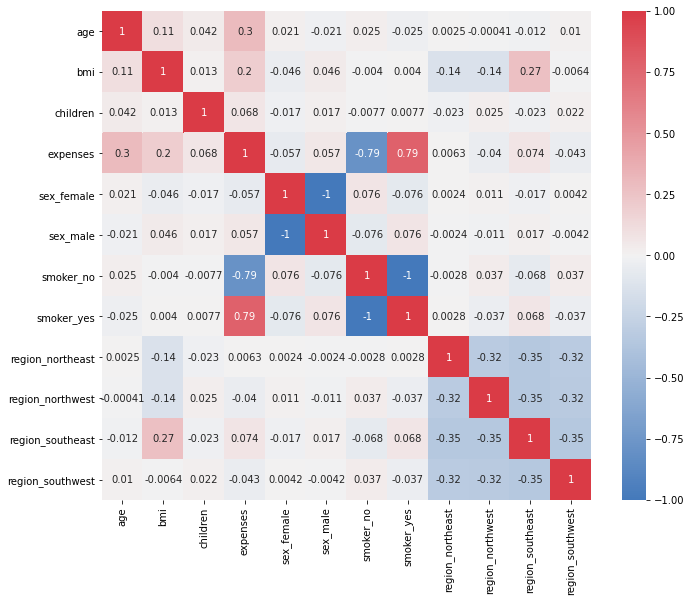

In [15]:
import seaborn as sns # Se importa la librería seaborn

corr = dataset_numeric.corr() # @corr: Calcula la correlación de las columnas del dataset numérico por parejas.

# Genera una máscara para el triángulo superior
mask = np.zeros_like(corr, dtype=np.bool)

# Configura la figura
f, ax = plt.subplots(figsize=(11, 9))

# Genera un mapa de color divergente aleatorio
cmap = sns.diverging_palette(220, 10, as_cmap=True) # @diverging_palette: Crea una paleta de colores divergente entre dos colores.

# Dibuja el mapa de calor con la máscara y con el ratio correcto
sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(250,10,as_cmap=True), # @heatmap: Dibuja un mapa de calor
            square=True,annot=True,ax=ax)

Now that we have plotted the heatmap with the correlation values, we can conclude the following:
- There is a **strong positive correlation between being a smoker and the healthcare costs** (0.79).
- There is a **strong negative correlation between not being a smoker and the healthcare costs** (-0.79).
- There is a **medium positive correlation between the age and the healthcare costs** (0.3).
- There is a **small positive correlation between the BMI and the healthcare costs** (0.2).
- **There are not significant correlations between the remaining features and the healthcare costs**.

Following these conclusions, we can do a deeper research of the features that have a significant correlation with the healthcare costs. To start with, we can plot a histogram of the healthcare costs of smokers and non smokers.

Text(0, 0.5, 'Frequency')

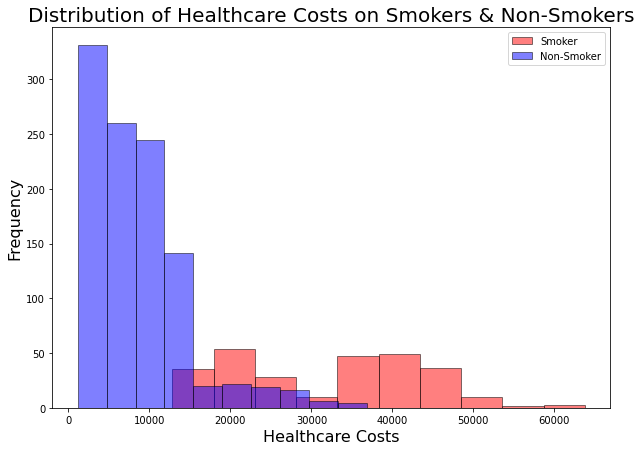

In [16]:
# Se seleccionan las columnas 'smoker_yes' y 'smoker_no' del dataset numérico y se dibujan los gastos sanitarios de estas columnas.
# @kind: Tipo de gráfica (histograma).
# @color: Color de las barras
# @alpha: Transparencia de las barras del gráfico.
# @edgecolor: Color de los bordes de las barras.
# @figsize: Tamaño de la figura (ancho,alto).
dataset_numeric[dataset_numeric['smoker_yes'] == 1].expenses.plot(kind='hist', color='red', edgecolor='black', 
                                                                  alpha=0.5, figsize=(10, 7))
dataset_numeric[dataset_numeric['smoker_no'] == 1].expenses.plot(kind='hist', color='blue', edgecolor='black', 
                                                                alpha=0.5, figsize=(10, 7))
plt.legend(labels=['Smoker', 'Non-Smoker']) # Rótulo para las leyendas del gráfico.
plt.title('Distribution of Healthcare Costs on Smokers & Non-Smokers', size=20) # Título de la gráfica y su tamaño
plt.xlabel('Healthcare Costs', size=16) # Rótulo en el Eje X y su tamaño.
plt.ylabel('Frequency', size=16) # Rótulo en el Eje Y y su tamaño.

We can see in the histogram that:
- There are more non smokers than smokers 
- Non smokers are paying less healthcare costs than smokers

To continue, we can make a scatter plot of the healthcare costs of smokers and non smokers depending on age.

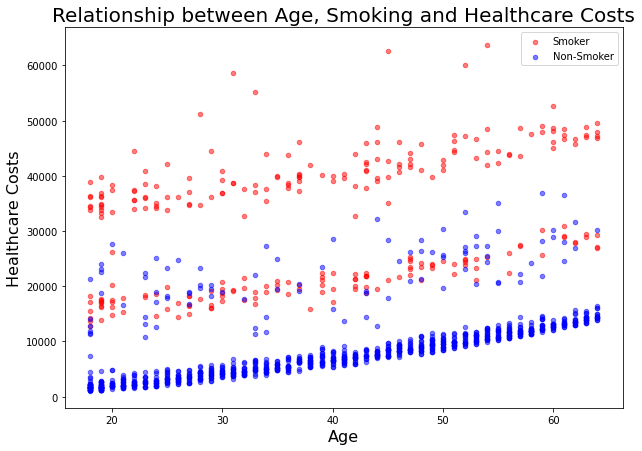

In [17]:
# Se seleccionan las columnas 'smoker_yes' y 'smoker_no' del dataset numérico y se dibujan los gastos sanitarios de estas columnas
# según la edad (Eje X: Edad; Eje Y: Gastos sanitarios).
# @kind: Tipo de gráfica (diagrama de dispersión).
# @x,y: Columnas seleccionadas para mostrar en los Ejes X e Y.
# @alpha: Transparencia de las barras del gráfico.
# @color: Color de los puntos.
# @figsize: Tamaño de la figura (ancho,alto).
# @ax: Argumento opcional para cargar ejes creados anteriormente en el diagrama actual.
ax1 = dataset_numeric[dataset_numeric['smoker_yes'] == 1].plot(kind='scatter', x='age', y='expenses', color='red', 
                                                               alpha=0.5, figsize=(10, 7))
dataset_numeric[dataset_numeric['smoker_no'] == 1].plot(kind='scatter', x='age', y='expenses', color='blue', 
                                                        alpha=0.5, figsize=(10 ,7), ax=ax1)

plt.legend(labels=['Smoker', 'Non-Smoker']) # Rótulo para las leyendas del gráfico.
plt.title('Relationship between Age, Smoking and Healthcare Costs', size=20) # Título de la gráfica y su tamaño.
plt.xlabel('Age', size=16) # Rótulo en el Eje X y su tamaño.
plt.ylabel('Healthcare Costs', size=16); # Rótulo en el Eje Y y su tamaño.

We can conclude from the scatter plot the following:
- Increasing age increases healthcare costs.
- Other variables such as BMI and childrens could also explain the deviation of points in the healthcare, straying away from the trend of smokers and non-smokers above.

To continue, we can make another scatter plot of the healthcare costs of smokers and non smokers depending on BMI.

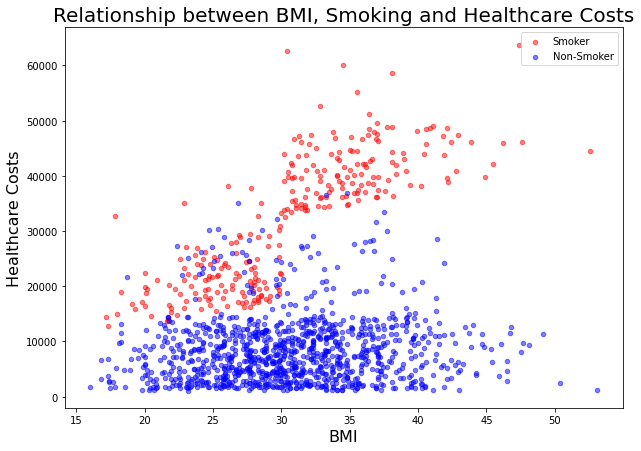

In [18]:
# Se seleccionan las columnas 'smoker_yes' y 'smoker_no' del dataset numérico y se dibujan los gastos sanitarios de estas columnas
# según el IMC (Eje X: IMC; Eje Y: Gastos sanitarios).
# @kind: Tipo de gráfica (diagrama de dispersión).
# @x,y: Columnas seleccionadas para mostrar en los Ejes X e Y.
# @alpha: Transparencia de las barras del gráfico.
# @color: Color de los puntos.
# @figsize: Tamaño de la figura (ancho,alto).
# @ax: Argumento opcional para cargar ejes creados anteriormente en el diagrama actual.
ax1 = dataset_numeric[dataset_numeric['smoker_yes'] == 1].plot(kind='scatter', x='bmi', y='expenses', color='red', 
                                                               alpha=0.5, figsize=(10, 7))
dataset_numeric[dataset_numeric['smoker_no'] == 1].plot(kind='scatter', x='bmi', y='expenses', color='blue', 
                                                        alpha=0.5, figsize=(10 ,7), ax=ax1)

plt.legend(labels=['Smoker', 'Non-Smoker']) # Rótulo para las leyendas del gráfico.
plt.title('Relationship between BMI, Smoking and Healthcare Costs', size=20) # Título de la gráfica y su tamaño.
plt.xlabel('BMI', size=16) # Rótulo en el Eje X y su tamaño.
plt.ylabel('Healthcare Costs', size=16); # Rótulo en el Eje Y y su tamaño.

We can conclude from this scatter plot the following:
- Increasing BMI increases healthcare costs.


To conclude the notebook, we can say that through analyzing the variables in the dataset we found that:
- Only your age, BMI, and being a smoker impacts healthcare costs. 
- Sex, region, and the number of children doesn't affect the price of healthcare costs.

---

**MEDICAL CHARGE WILL BE AFFECTED BECAUSE OF...**

---
- **Age**: The price of healthcare costs increases the older you become.
- **BMI**: The higher your BMI level, the higher your healthcare cost will be.
- **Smoker**: Healthcare costs will sky rocket if you're a smoker.

---

**MEDICAL CHARGE WILL NOT BE AFFECTED BECAUSE OF...**

---
- **Sex**: Your sex will not impact healthcare costs. Male or female, the healthcare prices are approximate.
- **Region**: Where you live will not affect the healthcare costs. The distribution of prices is about the same across all regions.
- **Number of Children**: The number of children dependent on you will not affect the price of your healthcare costs.